# 基于SRL的忏悔识别

In [1]:
import spacy
import pandas as pd
import numpy as np
nlp = spacy.load("en_core_web_lg")

In [61]:
sample_df = pd.read_csv("../data/last_words_sampled_rows.csv")
sample_statements = sample_df["last.statement"].tolist()
sample_statements

['I have come here today to die, not make speeches. Today is a good day for dying. My Honor Is My Life.',
 ' Tell Mama I love her.',
 nan,
 'I just want everyone to know that the prosecutor and Bill Scott are sorry sons of bitches. To his family he added that he loved them all.',
 nan,
 nan,
 " I'm innocent. I had nothing to do with my family's murders. I want to thank everyone who has supported me. I hope they continue to fight. You know who you are. That's all. Thank you, Warden.  ",
 "  Yes sir. To Edie, Tom, and and Carma - I love all you all.  I appreciate all your support.  I love you Margherita, Father Guido, and Father Angelo.  I appreciate your spiritual support and all those that were in prayer for me.  I will be O.K.  I am at peace with all of this and I won't have to wake up in prison any more.  I love you all.  I totally surrender to the Lord.  I am ready, Warden. ",
 ' Into your hands Oh Lord, I commence my spirit.  Amen.  ',
 "I would like to apologize to the Nix family 

## 找到文本中的受害者

In [3]:
def is_family_member(sentence, entity):
    """
    Determine if an entity in a sentence is a family member based on contextual clues.
    
    Args:
        sentence (str): The sentence containing the entity
        entity (spacy.tokens.span.Span): The entity to check
        
    Returns:
        bool: True if the entity is likely a family member, False otherwise
    """
    if entity.text == "God":
        return False
    # Family-related terms
    family_terms = [
        "family", "mother", "father", "mom", "dad", "brother", "sister", 
        "son", "daughter", "child", "children", "kids", "wife", "husband", 
        "spouse", "grandma", "grandpa", "grandmother", "grandfather", 
        "aunt", "uncle", "cousin", "niece", "nephew", "parents"
    ]
    
    # Create a spaCy Doc object
    doc = nlp(sentence)
    
    # Find the entity in the sentence
    entity_tokens = []
    entity_text = entity.text.lower()
    for token in doc:
        if token.text.lower() == entity_text:
            entity_tokens.append(token)
    
    if not entity_tokens:
        return False
    
    # Check if the entity is explicitly referred to as a family member
    for token in entity_tokens:
        # Look at a window of 5 tokens around the entity
        start = max(0, token.i - 5)
        end = min(len(doc), token.i + 6)
        window = doc[start:end]
        
        # Check if there are family terms in the window
        for w in window:
            if w.text.lower() in family_terms:
                return True
        
        # Check for possessive patterns like "my [entity]" or "[entity] is my..."
        for i, w in enumerate(window):
            if i < len(window) - 1 and w.text.lower() == "my" and window[i+1].text.lower() == entity_text:
                return True
                
        # Check for relationship indicators
        for w in window:
            if w.dep_ == "poss" and w.text.lower() in ["my", "our"]:
                return True
    
    return False

In [4]:
sample_statements[11]

"Tell my son I love him very much. God bless everybody. Continue to walk with God. Go Cowboys! Love ya'll man. Don't forget the T-ball. Ms. Mary, thank you for everything that you've done. You too, Brad, thank you. I can feel it, taste it, not bad."

In [ ]:
appologize_tokens = [
    'sorry',
    'apologize',
    'forgive',
    'regret',
    'remorse',
]
def regret_dector(statement):
    """
    This function takes a statement and returns 1 if it contains any of the words
    'sorry', 'apologize', 'regret', or 'forgive'. Otherwise, it returns 0.
    """
    doc = nlp(statement)
    # 对doc进行分句
    sentences = list(doc.sents)
    for sentence in sentences:
        # 首先，道歉的主语应当是自己，而不是他人
        sen = nlp(sentence.text)
        # 检查道歉的主语是否是自己
        if not any(token.text.lower() in ["i", "me", "myself"] for token in sen if token.dep_ == "nsubj"):
            continue
        # 检查道歉的谓语是否为自己的家人，如果是，则跳过此循环
        if any(token.text.lower() in ["family", "kids", "children", "mom", "dad", "parents"] for token in sen if token.dep_ == "dobj"):
            continue
        # 最后，检查是否存在道歉行为，首先，看是否有道歉的相关谓词
        for token in sen:
            if token.lemma_ in appologize_tokens:
                return 1
        # 检查句子中是否有承担责任的表达, 如果有，也返回1
        if any(token.text.lower() in ["responsibility", "accountable", "blame"] for token in sen):
            return 1
    return 0


In [76]:
appologize_tokens = [ # 这个列表可以保留用于参考或其他用途
    'sorry',
    'apologize',
    'forgive',
    'regret',
    'remorse',
]

def regret_dector(statement):
    """
    这个函数接受一个陈述并返回1如果它表明说话者有悔恨情绪。
    否则返回0。
    """
    if not isinstance(statement, str) or not statement.strip():
        return 0
        
    doc = nlp(statement)
    sentences = list(doc.sents)

    for sentence_span in sentences: # 直接使用Span对象

        # 过滤器1：句子必须包含"I"、"me"或"myself"作为主语。
        # 这有助于专注于说话者自己的悔恨陈述。
        if not any(token.text.lower() in ["i", "me", "myself"] for token in sentence_span if token.dep_ == "nsubj"):
            continue

        # 过滤器2：道歉不是（仅仅）针对说话者自己家庭的困难。
        # 这是原始代码中的一个细致过滤器。
        # 它检查直接宾语是否为家庭成员术语。
        # 这可能需要根据具体要求进一步完善。
        if any(token.text.lower() in ["family", "kids", "children", "mom", "dad", "parents"] for token in sentence_span if token.dep_ == "dobj"):
            continue

        # 检查道歉/悔恨表达
        for token in sentence_span:
            token_lemma = token.lemma_.lower()
            token_text = token.text.lower()

            # --- 处理"sorry" ---
            if token_lemma == 'sorry':
                is_regretful_sorry = False
                # 情况1："I am sorry"、"I feel sorry"
                # 'sorry'是形容词补语(acomp)或属性(attr)
                # 动词/助动词的主语是"I"。
                if token.dep_ in ['acomp', 'attr'] and token.head.pos_ in ['VERB', 'AUX']:
                    verb_head = token.head
                    if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in verb_head.children):
                        is_regretful_sorry = True
                # 情况2："Sorry, ..."（感叹词）
                elif token.pos_ == 'INTJ':
                    is_regretful_sorry = True
                # 情况3："Sorry about that."（'sorry'作为句子的根且是形容词）
                elif token.dep_ == 'ROOT' and token.pos_ == 'ADJ':
                    is_regretful_sorry = True
                
                if is_regretful_sorry:
                    return 1
                # 如果'sorry'是形容词修饰语(amod)，如"sorry sons of bitches"中的用法，
                # 它不会匹配上述条件，也不会被计为悔恨。

            # --- 处理道歉动词（apologize、forgive、regret）---
            elif token_lemma in ['apologize', 'forgive', 'regret'] and token.pos_ == 'VERB':
                verb_is_by_speaker = False
                # 检查"I"是否是这个动词的直接主语
                if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in token.children):
                    verb_is_by_speaker = True
                # 检查像"I want to apologize"这样的模式（动词是xcomp，主动词的主语是"I"）
                elif token.dep_ == 'xcomp' and token.head.pos_ in ['VERB', 'AUX']:
                    main_verb = token.head
                    if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in main_verb.children):
                        verb_is_by_speaker = True
                
                if verb_is_by_speaker:
                    return 1

            # --- 处理道歉名词（remorse、regret）---
            elif token_lemma in ['remorse', 'regret'] and token.pos_ == 'NOUN':
                noun_is_by_speaker = False
                # 检查"I have/feel remorse/regret"（名词是动词的直接宾语，动词的主语是"I"）
                if token.dep_ == 'dobj' and token.head.pos_ in ['VERB', 'AUX']:
                    verb_head = token.head
                    if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in verb_head.children):
                        noun_is_by_speaker = True
                # 检查"my remorse/regret"（名词是主语或宾语，被"my"所拥有）
                elif any(child.dep_ == 'poss' and child.text.lower() == 'my' for child in token.children):
                    noun_is_by_speaker = True

                if noun_is_by_speaker:
                    return 1

        # 检查承担责任（与"I"相关）
        for token in sentence_span:
            token_text = token.text.lower()
            # "I take/accept responsibility"
            if token_text == "responsibility" and token.dep_ == 'dobj' and \
               token.head.pos_ == 'VERB' and token.head.lemma_ in ['take', 'accept', 'assume']:
                action_verb = token.head
                if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in action_verb.children):
                    return 1
            # "I am accountable"
            elif token_text == "accountable" and token.dep_ in ['acomp', 'attr'] and \
                 token.head.pos_ in ['VERB', 'AUX']:
                copula_verb = token.head
                if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in copula_verb.children):
                    return 1
            # "I take the blame"或"I blame myself"
            elif token_text == "blame":
                # "I take/accept the blame"（blame作为名词）
                if token.pos_ == 'NOUN' and token.dep_ == 'dobj' and \
                   token.head.pos_ == 'VERB' and token.head.lemma_ in ['take', 'accept', 'assume']:
                    action_verb = token.head
                    if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in action_verb.children):
                        return 1
                # "I blame myself"（blame作为动词）
                elif token.pos_ == 'VERB' and token.lemma_ == 'blame':
                    subj_is_i = any(child.dep_ == 'nsubj' and child.text.lower() == 'i' for child in token.children)
                    dobj_is_myself = any(child.dep_ == 'dobj' and child.text.lower() == 'myself' for child in token.children)
                    if subj_is_i and dobj_is_myself:
                        return 1
    return 0

In [39]:
df = pd.read_csv("../data/raw_last_statement.csv")
df.head()

,execution,length,last_statement
0,593,219.0,There is not a day that goes by that I don't r...
1,592,54.0,"I will always love you no matter, that our lov..."
2,591,168.0,"Yes ma'am, first I would like to apologize for..."
3,590,142.0,"Yes Warden, I would like to thank everyone, al..."
4,589,78.0,Yes. I want to say thank you to all the people...


In [55]:
df['nlp_sentence'] = df['last_statement'].apply(lambda x: regret_dector(str(x)))

In [56]:
df.head()

,execution,length,last_statement,nlp_sentence
0,593,219.0,There is not a day that goes by that I don't r...,1
1,592,54.0,"I will always love you no matter, that our lov...",0
2,591,168.0,"Yes ma'am, first I would like to apologize for...",1
3,590,142.0,"Yes Warden, I would like to thank everyone, al...",1
4,589,78.0,Yes. I want to say thank you to all the people...,1


In [72]:
sample_df = pd.read_csv("../data/last_words_sampled_rows.csv")
def to_bin(x):
    return 1 if x >= 0.8 else 0
sample_df['label-penitence'] = sample_df['label-penitence'].apply(lambda x: to_bin(x))
sample_df.head()

,Unnamed: 0,execution,length,last.statement,label-penitence,label-opion-on-capital-punishment
0,415,157,22,"I have come here today to die, not make speech...",0,0.5
1,463,109,5,Tell Mama I love her.,0,0.5
2,179,393,0,NaN,0,0.5
3,526,46,27,I just want everyone to know that the prosecut...,0,0.5
4,195,377,0,NaN,0,0.5


In [73]:
test_df = pd.merge(sample_df, df[['execution', 'nlp_sentence']], on='execution', how='left')
test_df.head(20)

,Unnamed: 0,execution,length,last.statement,label-penitence,label-opion-on-capital-punishment,nlp_sentence
0,415,157,22,"I have come here today to die, not make speech...",0,0.5,0
1,463,109,5,Tell Mama I love her.,0,0.5,0
2,179,393,0,NaN,0,0.5,0
3,526,46,27,I just want everyone to know that the prosecut...,0,0.5,0
4,195,377,0,NaN,0,0.5,0
5,118,454,0,NaN,0,0.5,0
6,299,273,36,I'm innocent. I had nothing to do with my fam...,0,0.0,0
7,229,343,79,"Yes sir. To Edie, Tom, and and Carma - I lov...",0,0.5,0
8,244,328,10,"Into your hands Oh Lord, I commence my spirit...",0,0.5,0
9,14,580,35,I would like to apologize to the Nix family fo...,1,1.0,1


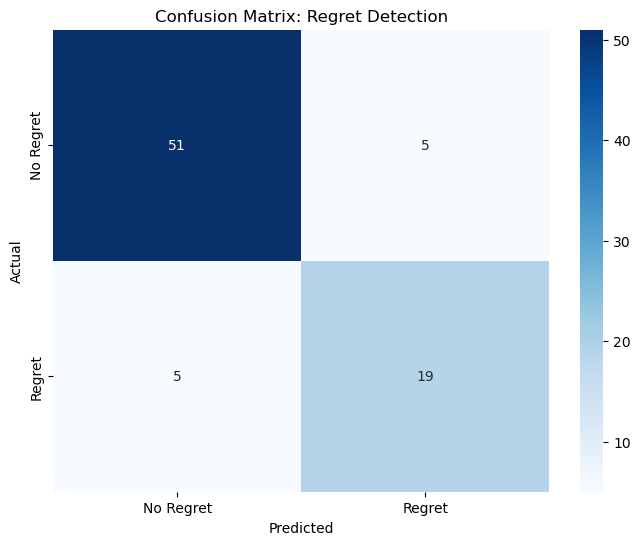

Confusion Matrix:
[[51  5]
 [ 5 19]]

True Negatives: 51
False Positives: 5
False Negatives: 5
True Positives: 19


In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(test_df['label-penitence'], test_df['nlp_sentence'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Regret', 'Regret'], 
            yticklabels=['No Regret', 'Regret'])
plt.title('Confusion Matrix: Regret Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../visualize/confusion_matrix_regret_detection.png', dpi=600)
plt.show()

# Print confusion matrix details
print("Confusion Matrix:")
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

In [75]:
print(70/80)

0.875


In [65]:
test_df.loc[12]['last.statement']

" Kathy, y'all take and I bless all of you and I am glad I have had y'all in my life. As I have said from the very first thing, I am innocent of this crime and God knows I am innocent and the four people that was murdered know I am innocent and when I get to heaven I'll be hunting you and we'll talk. I feel sorry for the families that's had to suffer and my family and I have 'em all in my prayers. I love you all. Y'all take and y'all look after Sheila and Shannon and them, call 'em and get the pictures to 'em and everything and, ah, again, like I said, I feel sorry for the families, but if it takes my death to make them happy, then I will bless them. I have no hard feelings toward anyone cause the Lord feels that it is my time to come home to Him, my work on earth is done and that, ah, like I said, I am just sorry for, but they will have to go through this one time again, cause sooner or later, whoever did this crime is going to be caught and they'll have to come down here and do this 

In [48]:
regret_dector(test_df.loc[3]['last.statement'])

0